## 07 - Image segmentation

(Moacir A. Ponti, ICMC/USP, 2019)

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

Image segmentation is the process of dividing the image into regions so that the pixels within a given region are related according to some criterion. Depending on the problem, the criterion may be subjective making it difficult to produce an accurate segmentation.

Therefore, many different segmentation approaches were explored in the image processing literature, often based on thresholding of intensity (or colour) values, and on finding discontinuities on image pixels.

### Part 1 - Thresholding-based segmentation
In this approach, segmentation is performed by dividing pixels into two or more categories or classes. We can interpret this as finding a threshold in the image histogram, or performing a point operation over all pixels values $r$ in the image given a threshold value $L$:
$$s= T(r,L) =  \left\lbrace 
        \begin{array}{ll}
                    1 &, \text{ if } r > L,\\
                    0 &, \text{ otherwise}.
        \end{array} \right.$$
        
In order to visualize this idea, let us create a toy example using a random image and look at its histogram

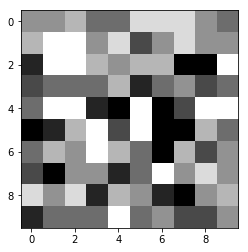

In [2]:
# Let us create a random matrix and threshold it
np.random.seed(333) # defining a seed
# random image with 5x5 size
f = np.random.randint(0,8, [10,10])
plt.imshow(f,cmap="gray")

<BarContainer object of 8 artists>

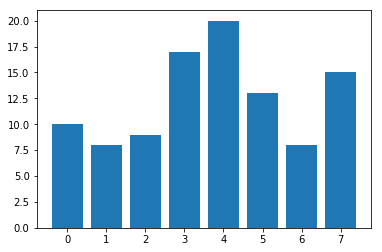

In [3]:
hist,_ = np.histogram(f, bins=8, range=(0,8))
plt.bar(np.arange(0,8), hist)

A function to threshold a given image can be written as follows. Note that, when applying different threshold values, we change the amount of black and white pixels on the resulting image. A lower threshold allows more white (value 1) pixels.

In [4]:
def thresholding(f, L):
    # create a new image with zeros
    f_tr = np.ones(f.shape).astype(np.uint8)
    # setting to 1 the pixels above the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr    

<BarContainer object of 8 artists>

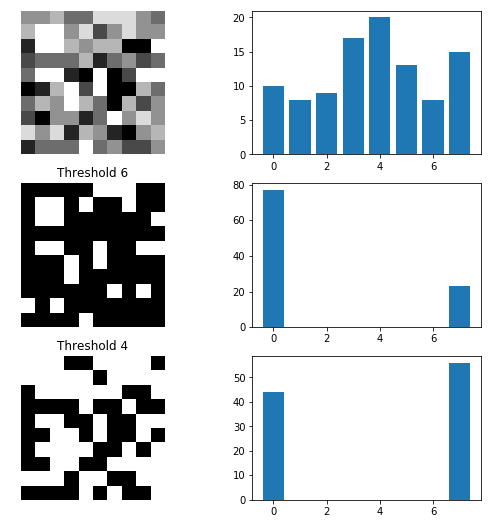

In [5]:
f_thres6 = thresholding(f, 6)
hist_t6,_ = np.histogram(f_thres6*7, bins=8, range=(0,8))

f_thres4 = thresholding(f, 4)
hist_t4,_ = np.histogram(f_thres4*7, bins=8, range=(0,8))

plt.figure(figsize=(9,9))
plt.subplot(321); plt.imshow(f,cmap="gray"); plt.axis('off')
plt.subplot(322); plt.bar(np.arange(0,8), hist)
plt.subplot(323); plt.imshow(f_thres6,cmap="gray"); plt.axis('off'); plt.title('Threshold 6')
plt.subplot(324); plt.bar(np.arange(0,8), hist_t6)
plt.subplot(325); plt.imshow(f_thres4,cmap="gray"); plt.axis('off'); plt.title('Threshold 4')
plt.subplot(326); plt.bar(np.arange(0,8), hist_t4) 

Let us use the same function but now for a real image. The mean intensity value is used as threshold in this example.

<BarContainer object of 256 artists>

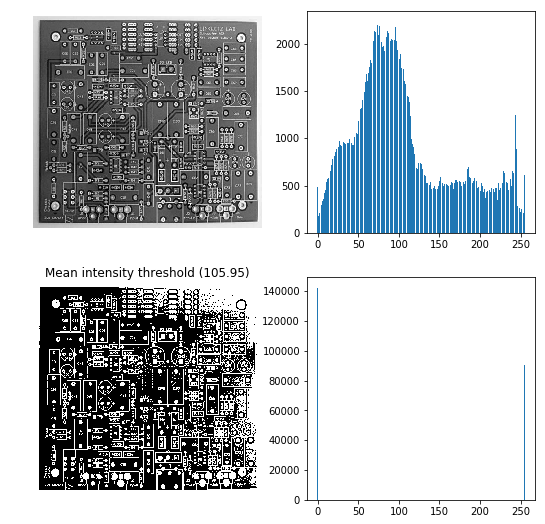

In [6]:
img = imageio.imread("images/board.jpg")

mean_v = np.mean(img)
img_t = thresholding(img, mean_v)

hist_img,_ = np.histogram(img, bins=256, range=(0,256))
hist_t,_ = np.histogram(img_t*255, bins=256, range=(0,256))

plt.figure(figsize=(9,9))
plt.subplot(221); plt.imshow(img,cmap="gray"); plt.axis('off')
plt.subplot(222); plt.bar(np.arange(0,256), hist_img)
plt.subplot(223); plt.imshow(img_t, cmap="gray"); plt.axis('off'); plt.title('Mean intensity threshold (%.2f)' % (mean_v))
plt.subplot(224); plt.bar(np.arange(0,256), hist_t)

As noted, defining a proper threshold may be difficult. 

There are automatic ways to find an *global optimum threshold* assuming the intensity distribution is bimodal. The most well known method was proposed by Otsu and performs a search along all possible threshold values, choosing the threshold that minimises the intra-group variance. By *group* we mean two group of pixels $a$ and $b$ in which we want to divide the image into. 

Let $\sigma^2(L_i)$ be the intra-group variance when using threshold $L_i$. This can be computed by the weighted sum of variances $\sigma^2_a$ and $\sigma^2_b$ relative to groups $G_a$ and $G_b$:
 $$\sigma^2(L_i) = w_a\sigma^2_a(L_i) + w_b\sigma^2_b(L_i)$$
 
The global optimum threshold is found by minimizing the variance:
$$L^* = \arg\min_{L_i} [ \sigma^2(L_i)]$$


In [7]:
def otsu_threshold(img, max_L):
    
    M = np.product(img.shape)
    min_var = []
    hist_t,_ = np.histogram(img, bins=256, range=(0,256))
    
    img_t = thresholding(img, 0)
    
    for L in np.arange(1, max_L):
        img_ti = thresholding(img, L)
        # computing weights
        w_a = np.sum(hist_t[:L])/float(M)
        w_b = np.sum(hist_t[L:])/float(M)
        # computing variances
        sig_a = np.var(img[np.where(img_ti == 0)])
        sig_b = np.var(img[np.where(img_ti == 1)])
        
        min_var = min_var + [w_a*sig_a + w_b*sig_b]
        
    img_t = thresholding(img, np.argmin(min_var))
    
    return img_t, np.argmin(min_var)

<BarContainer object of 256 artists>

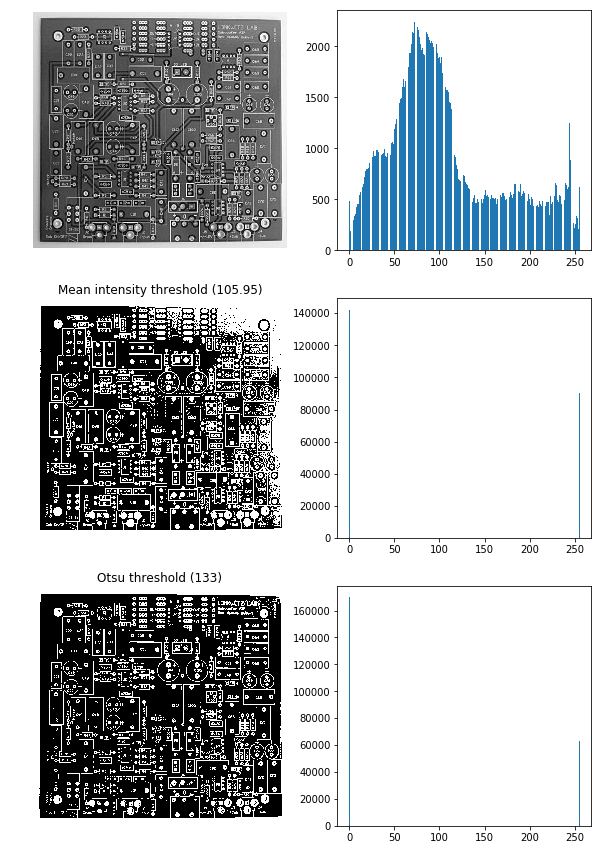

In [8]:
img_o, OL = otsu_threshold(img, 255)

hist_o,_ = np.histogram(img_o*255, bins=256, range=(0,256))

plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(img,cmap="gray"); plt.axis('off')
plt.subplot(322); plt.bar(np.arange(0,256), hist_img)
plt.subplot(323); plt.imshow(img_t, cmap="gray"); plt.axis('off'); plt.title('Mean intensity threshold (%.2f)' % (mean_v))
plt.subplot(324); plt.bar(np.arange(0,256), hist_t)
plt.subplot(325); plt.imshow(img_o, cmap="gray"); plt.axis('off'); plt.title('Otsu threshold (%d)' % (OL))
plt.subplot(326); plt.bar(np.arange(0,256), hist_o)

### Part 2 - Region growing

Instead of using histograms, region growing is oft used to segment images. In this case we need to define seed from where to start processing, agreggating new pixels to the region.

In this approach, it is paramount to define a suitable criterion for pixel conquering and also the stopping condition.

The example below shows a type of Depth-first search on the 4 neigbours, starting with the seed pixel, and conquering new pixels if that pixel value is similar to the average of the current region

In [9]:
def distance(a, b):
    return np.abs(a-b)

def region_growing_average(img, img_t, tolerance, seed):
    
    #img_t = np.zeros(img.shape)
    x = seed[0]; y = seed[1]

    img_t[x, y] = 1
    
    avg = np.mean(img[np.where(img_t==1)])
    
    # check matrix border and conquering criterion for the 4-neigbourhood
    if (y+1 < img.shape[1] and img_t[x,y+1] == 0 and distance(avg, img[x, y+1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y+1])
        
    if (y-1 >= 0 and img_t[x,y-1] == 0  and distance(avg, img[x, y-1]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x, y-1])
        
    if (x+1 < img.shape[0] and img_t[x+1,y] == 0  and distance(avg, img[x+1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x+1, y])
        
    if (x-1 >= 0 and img_t[x-1,y] == 0  and distance(avg, img[x-1, y]) <= tolerance):
        region_growing_average(img, img_t, tolerance, [x-1, y])
        
    #return img_t
    

In [10]:
img_test = np.zeros([15,15])
img_test[2:5, 5:13] = 100 + np.random.randint(0,3,[3, 8])
img_test[5:13, 2:5] = 150 + np.random.randint(0,20,[8, 3])

img_seed1 = np.zeros(img_test.shape)
img_seed2 = np.zeros(img_test.shape)

region_growing_average(img_test, img_seed1, 10, [3,6])
region_growing_average(img_test, img_seed2, 5, [6,3])

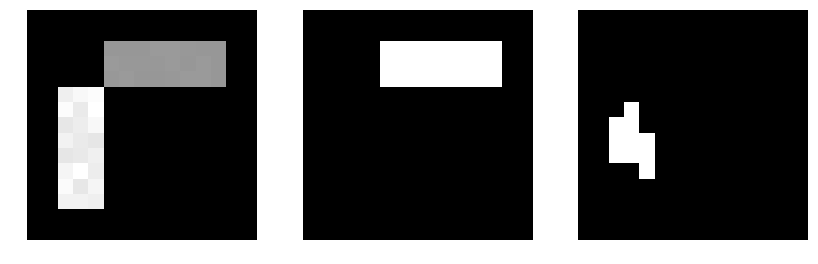

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(131); plt.imshow(img_test,cmap="gray"); plt.axis('off')
plt.subplot(132); plt.imshow(img_seed1*255, cmap="gray"); plt.axis('off');
plt.subplot(133); plt.imshow(img_seed2*255, cmap="gray"); plt.axis('off');


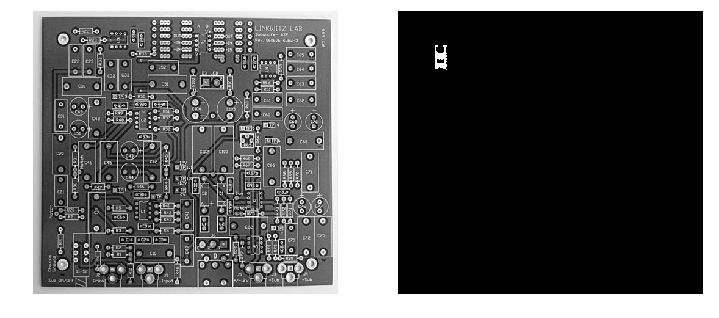

In [12]:
img_seed = np.zeros(img.shape)
region_growing_average(img, img_seed, 25, [60,60])

plt.figure(figsize=(12,6))
plt.subplot(121); plt.imshow(img,cmap="gray"); plt.axis('off')
plt.subplot(122); plt.imshow(img_seed*255, cmap="gray"); plt.axis('off');


As shown in the last example, region groring methods are useful to segment specific regions. We can apply other steps on the top of the first one and compose the image

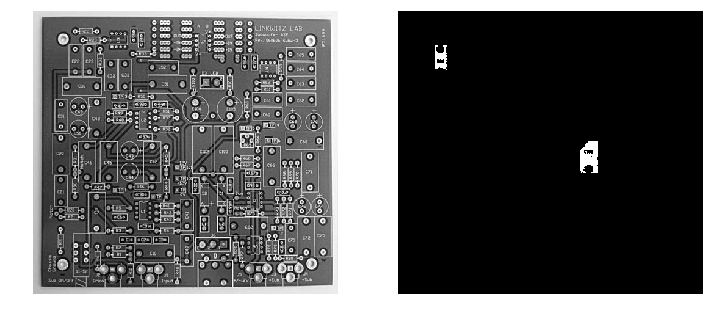

In [13]:
region_growing_average(img, img_seed, 25, [256,300])

plt.figure(figsize=(12,6))
plt.subplot(121); plt.imshow(img,cmap="gray"); plt.axis('off')
plt.subplot(122); plt.imshow(img_seed*255, cmap="gray"); plt.axis('off');


The way we implemented was using recursion, what can be dangerous for large images if the number of recursive calls increases. Implementing a virtual stack is recommended in this scenario.